## Hovmöller plot of temperature at 2 m along the coast

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

In [2]:
def create_nc_file(dist_array, time_array, curtain_data, filename,
                   title, description, units='m', name='SSH'):
    
    """ This function creates a netCDF4 file for
    the curtain plot data given the filename. 
    
    :arg dist_array: np 2D array, distance from bay array from meshgrid
    :arg time_array: np 2D array, time array from meshgrid
    :arg curtain_data: np 2D array of data to plot in curtain hovmöller. Size is (len(dist_array),len(time_array))
    :arg filename: str, Directory and name of netcdf file
    :arg title: str, title of plot
    :arg description: str, Details about the data
    """
    dataset = Dataset(filename, 'w')
    file_x = dataset.createDimension('x', curtain_data.shape[1])
    file_t = dataset.createDimension('t', curtain_data.shape[0])

    file_X = dataset.createVariable('X', 'f8', ('x'))
    file_T = dataset.createVariable('T', 'f8', ('t'))
    curt_data = dataset.createVariable('curtain_data', 'f8', ('t','x'))

    dataset.title = title
    dataset.author = 'Karina Ramos Musalem'
    dataset.institution = 'ICACC-UNAM'
    dataset.source = '/notebooks/MITgcm/domain5/ssh_hovmoller_at_coast_all_points.ipynb'
    dataset.description = description
    dataset.timeStamp = time.ctime(time.time())
    file_X.standard_name = 'Distance along the coast from SVB'
    file_X.units = 'km'
    file_T.standard_name = 'time'
    file_T.units = 's'
    curt_data.standard_name = name
    curt_data.units = units
    
    file_X[:] = dist_array[:]
    file_T[:] = time_array[:]
    curt_data[:] = curtain_data[:]

    dataset.close()

In [3]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

In [4]:
nx = 512
ny = 612
nz = 100
nt = 720

In [5]:
depth = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# No bay centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

# bay centers mask
# centers mask
depthSVB = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)
dep_maskedSVB = np.ma.masked_values(depthSVB,0)
mask_depSVB = np.ma.getmask(dep_maskedSVB)

### 1. Find lon index of first water point from east to west for each lat

Find cells along lat where hFacC is 1.

In [6]:
lon_inds_off = np.argmax(np.squeeze(hFacCSVB[0,:,::-1].data), axis=1)

ini_lat_ind = 220 # Lat just above and outside SVB

lon_inds = np.ones_like(lon_inds_off[ini_lat_ind:])*nx - lon_inds_off[ini_lat_ind:]
lat_inds = np.ones_like(lon_inds)*ini_lat_ind + np.arange(len(lon_inds))

There are some points missing along the coast that have the same lat. Now find along lon:

In [7]:
lat_inds_off = np.argmax(np.squeeze(hFacCSVB[0,::-1,:].data), axis=0)
ini_lon_ind = 50 # Lon of land at N boundary

lat_inds_2 = np.ones_like(lat_inds_off[ini_lon_ind:])*ny - lat_inds_off[ini_lon_ind:]
lon_inds_2 = np.ones_like(lat_inds)*ini_lon_ind + np.arange(len(lat_inds))

In [8]:
df = pd.read_csv('coastline_points_list.txt',names=['lon_ii','lat_jj'], header=1 )

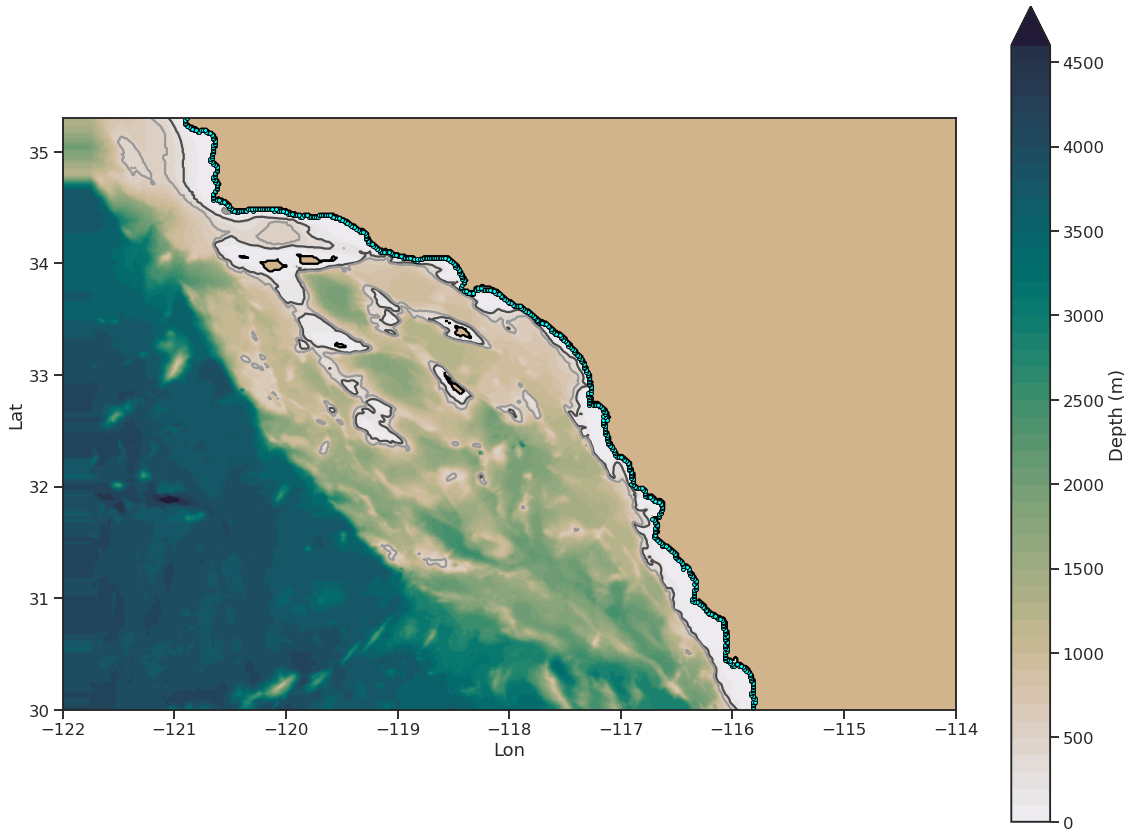

In [9]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(20,15))
ax.set_facecolor('tan')
pc = ax.contourf(lon,lat,np.ma.masked_array(depthSVB, mask=mask_depSVB),50,
                 vmin=0, vmax=5000, cmap=cmo.cm.rain, extend='max')
cb = plt.colorbar(pc, extend='max',label='depth / m')
cn = ax.contour(lon,lat,depth, colors=['0.3','0.6'], 
                levels=[250,500])

ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='k')

# cells along coast(ish)
for ii,jj in zip(df.lon_ii[:], df.lat_jj[:]):
    #print(ii,jj)
    ax.plot(LON[0,int(ii)-1],LAT[int(jj)-1,0],'o', 
            markersize=4, color='cyan', markeredgecolor='k')
    #print('%d %d Depth at cell is %1.2f m' % (int(ii),int(jj),depth[jj-1,ii-1]))

cb.set_label('Depth (m)')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(238-360, 246-360)
ax.set_ylim(30,35.3)
ax.set_aspect(1)

### Hovmöller 

In [10]:
lon_ii = np.array(df.lon_ii[:])-np.ones_like(df.lon_ii)
lat_jj = np.array(df.lat_jj[:])-np.ones_like(df.lat_jj)

In [11]:
# Distance along the coast (haversine)
def distance(lat1,lon1,lat2,lon2):
    '''Distance Haversine using formula'''
    r = 6371 #radius of Earth (KM)
    p = np.pi/180  #Pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p)*np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p)) / 2
    d = 2 * r * np.arcsin(np.sqrt(a)) #2*R*asin In km
    return d

In [12]:
dist_array = np.zeros(len(lon_ii))

for kk in range(1,len(lon_ii)):
    lat1 = lat[lat_jj[kk-1]]
    lon1 = lon[lon_ii[kk-1]]
    lat2 = lat[lat_jj[kk]]
    lon2 = lon[lon_ii[kk]]
    dist_array[kk]=  distance(lat1, lon1, lat2, lon2)

In [13]:
dist_cummul = np.cumsum(dist_array)

In [35]:
TH = np.zeros((nt,len(lon_ii)))
S = np.zeros((nt,len(lon_ii)))
U = np.zeros((nt,len(lon_ii)))
V = np.zeros((nt,len(lon_ii)))

In [ ]:
# This cell takes a while (about 30 min)
for ii,jj,kk in zip(lon_ii, lat_jj, range(len(lon_ii))):
    TH[:,kk] = np.squeeze(ds['THETA'][:,0,jj,ii])
    S[:,kk] = np.squeeze(ds['SALT'][:,0,jj,ii])
    U[:,kk] = ds['UVEL'][:,0,jj,ii]
    V[:,kk] = ds['VVEL'][:,0,jj,ii]

In [ ]:
filename = 'curtain_T_SVB_febTS.nc'
description = 'Temperature at 3m at points along the coast to build curtain hovmöller plot'
title = 'Temp 3m curtain plot data febTS SVB'

create_nc_file(dist_cummul, times, TH, filename,
               title, description, units='m', name='T')

In [ ]:
filename = 'curtain_S_SVB_febTS.nc'
description = 'Salinity at 3m at points along the coast to build curtain hovmöller plot'
title = 'Salinity 3m curtain plot data febTS SVB'

create_nc_file(dist_cummul, times, S, filename,
               title, description, units='m', name='S')

In [ ]:
filename = 'curtain_U_SVB_febTS.nc'
description = 'U at 3m vel at points along the coast to build curtain hovmöller plot'
title = 'U vel 3m curtain plot data febTS SVB'

create_nc_file(dist_cummul, times, U, filename,
               title, description, units='m', name='U')

In [ ]:
filename = 'curtain_V_SVB_febTS.nc'
description = 'V vel at 3m at points along the coast to build curtain hovmöller plot'
title = 'V vel 3m curtain plot data febTS SVB'

create_nc_file(dist_cummul, times, V, filename,
               title, description, units='m', name='V')

In [16]:
print('%1.1e' %distance(lat1,lon1,lat2,lon2))

2.1e+00


Text(0.5, 1.0, 'SVB run')

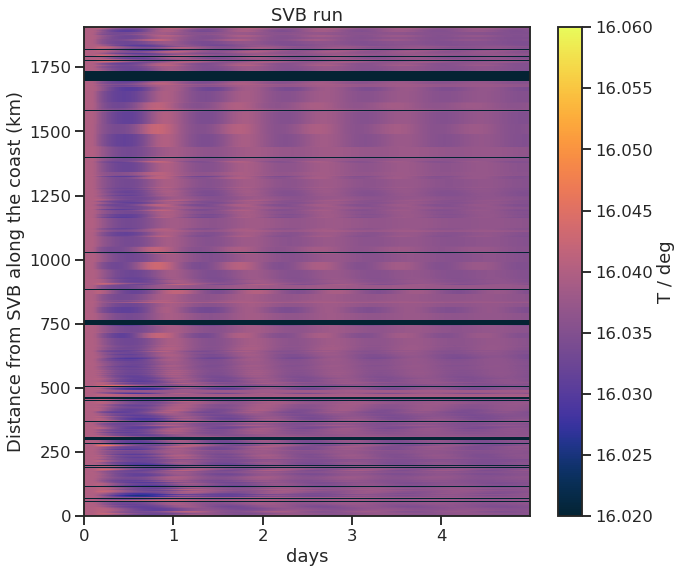

In [23]:
time = np.arange(720)*600

sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')

pc = ax.pcolormesh(time/(3600*24),dist_cummul,np.transpose(TH),
                   vmin=16.02, vmax=16.06, cmap=cmo.cm.thermal)
cb = plt.colorbar(pc,label='T / deg')
ax.set_ylabel('Distance from SVB along the coast (km)')
ax.set_xlabel('days')
ax.set_title('SVB run')

In [28]:
print('%1.1f' %ds['Z'][0])

-3.0
